# Lab 7: Neural networks 

In this lab we will build dense neural networks on the MNIST dataset.

Make sure you read the tutorial for this lab first.

## Load the data and create train-test splits

In [2]:
# Global imports and settings
from preamble import *
import tensorflow.keras as keras
print("Using Keras",keras.__version__)
%matplotlib inline

Using Keras 2.4.0


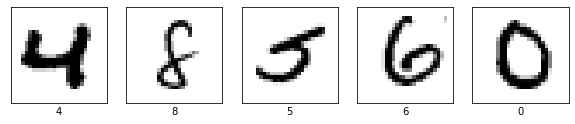

In [3]:
# Download MNIST data. Takes a while the first time.
mnist = oml.datasets.get_dataset(554)
X, y, _, _ = mnist.get_data(target=mnist.default_target_attribute, dataset_format='array');
X = X.reshape(70000, 28, 28)

# Take some random examples
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X[n], cmap=plt.cm.gray_r)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel("{}".format(y[n]))
plt.show();

In [4]:
# For MNIST, there exists a predefined stratified train-test split of 60000-10000. We therefore don't shuffle or stratify here.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000, random_state=0)

## Exercise 1: Preprocessing
* Normalize the data: map each feature value from its current representation (an integer between 0 and 255) to a floating-point value between 0 and 1.0. 
* Store the floating-point values in `x_train_normalized` and `x_test_normalized`.
* Map the class label to a on-hot-encoded value. Store in `y_train_encoded` and `y_test_encoded`.

In [5]:
from sklearn.preprocessing import LabelBinarizer

X_train_normalized = X_train / 255
X_test_normalized = X_test / 255

lb = LabelBinarizer()
lb.fit(y)
y_train_encoded = lb.transform(y_train)
y_test_encoded = lb.transform(y_test)

## Exercise 2: Create a deep neural net model

Implement a `create_model` function which defines the topography of the deep neural net, specifying the following:

* The number of layers in the deep neural net: Use 2 dense layers for now.
* The number of nodes in each layer: these are parameters of your function.
* Any regularization layers. Add at least one dropout layer.
* The optimizer and learning rate. Make the learning rate a parameter of your function as well.

Consider:
* What should be the shape of the input layer?
* Which activation function you will need for the last layer, since this is a 10-class classification problem?

In [6]:
### Create and compile a 'deep' neural net
def create_model(layer_1_units=32, layer_2_units=10, learning_rate=0.001, dropout_rate=0.3):
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.Dense(layer_1_units, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(layer_2_units, activation='softmax')
    ])
    opt = keras.optimizers.RMSprop(learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

## Exercise 3: Create a training function
Implement a `train_model` function which trains and evaluates a given model.
It should do a train-validation split and report the train and validation loss and accuracy, and return the training history.

In [13]:
def train_model(model, X, y, validation_split=0.1, epochs=10, batch_size=None, **kwargs):
    """
    model: the model to train
    X, y: the training data and labels
    validation_split: the percentage of data set aside for the validation set
    epochs: the number of epochs to train for
    batch_size: the batch size for minibatch SGD
    """
    return model.fit(X, y, validation_split=validation_split, epochs=epochs, batch_size=batch_size, **kwargs)

## Exercise 4: Evaluate the model

Train the model with a learning rate of 0.003, 50 epochs, batch size 4000, and a validation set that is 20% of the total training data.
Use default settings otherwise. Plot the learning curve of the loss, validation loss, accuracy, and validation accuracy. Finally, report the performance on the test set.

Feel free to use the plotting function below, or implement the callback from the tutorial to see results in real time.

In [8]:
# Helper plotting function
#
# history: the history object returned by the fit function
# list_of_metrics: the metrics to plot
def plot_curve(history, list_of_metrics):
    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m, lw=2)

    plt.legend()

In [9]:
model = create_model(learning_rate=0.003)
history = train_model(model, X_train_normalized, y_train_encoded, epochs=50, batch_size=4000, validation_split=0.2)

Epoch 1/50
12/12 [==============================] - 1s 30ms/step - loss: 1.7937 - accuracy: 0.4024 - val_loss: 0.8011 - val_accuracy: 0.8207
Epoch 2/50
12/12 [==============================] - 0s 10ms/step - loss: 0.8826 - accuracy: 0.7436 - val_loss: 0.5716 - val_accuracy: 0.8593
Epoch 3/50
12/12 [==============================] - 0s 11ms/step - loss: 0.6764 - accuracy: 0.8018 - val_loss: 0.4592 - val_accuracy: 0.8788
Epoch 4/50
12/12 [==============================] - 0s 11ms/step - loss: 0.5753 - accuracy: 0.8327 - val_loss: 0.3953 - val_accuracy: 0.8932
Epoch 5/50
12/12 [==============================] - 0s 11ms/step - loss: 0.5059 - accuracy: 0.8521 - val_loss: 0.3542 - val_accuracy: 0.9030
Epoch 6/50
12/12 [==============================] - 0s 10ms/step - loss: 0.4575 - accuracy: 0.8684 - val_loss: 0.3309 - val_accuracy: 0.9053
Epoch 7/50
12/12 [==============================] - 0s 11ms/step - loss: 0.4277 - accuracy: 0.8743 - val_loss: 0.3043 - val_accuracy: 0.9147
Epoch 8/50
12

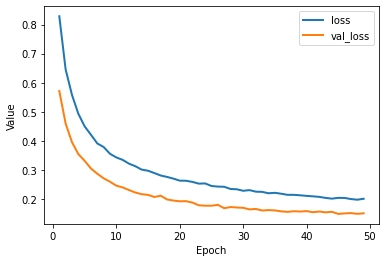

In [10]:
plot_curve(history, ['loss','val_loss'])

## Exercise 5: Optimize the model

Try to optimize the model, either manually or with a tuning method. At least optimize the following:
* the number of hidden layers 
* the number of nodes in each layer
* the amount of dropout layers and the dropout rate

Try to reach at least 96% accuracy against the test set.

In [14]:
from IPython.display import clear_output

# For plotting the learning curve in real time
class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        self.max_acc = 0
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.max_acc = max(self.max_acc, logs.get('val_accuracy'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure(figsize=(8,3))
            plt.plot(N, self.losses, lw=2, c="b", linestyle="-", label = "train_loss")
            plt.plot(N, self.acc, lw=2, c="r", linestyle="-", label = "train_acc")
            plt.plot(N, self.val_losses, lw=2, c="b", linestyle=":", label = "val_loss")
            plt.plot(N, self.val_acc, lw=2, c="r", linestyle=":", label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}, Max Acc {:.4f}]".format(epoch, self.max_acc))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

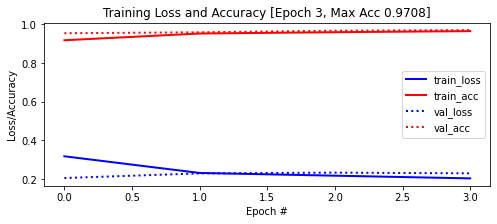

In [21]:
from tensorflow.keras import callbacks

plot_losses = TrainingPlot()
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=3)
model = create_model(learning_rate=0.001, layer_1_units=512)
history = train_model(
    model, X_train_normalized, y_train_encoded, validation_split=0.2,
    epochs=50, batch_size=32,
    callbacks=[earlystop, plot_losses]
)